In [ ]:
!git clone https://github.com/alexeygrigorev/clothing-dataset.git

In [6]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Activation, BatchNormalization
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
np.random.seed(0)

In [2]:
dataset_path = './clothing-dataset'
dataset_metadata = pd.read_csv(os.path.join(dataset_path,'images.csv'))
images_path = os.path.join(dataset_path,'images')
extension = '.jpg'
print(dataset_metadata.shape)
# dataset_metadata.tail(20)

(5403, 4)


In [3]:
# Utilities functions

def get_image_path(img_id,base_path,extension='.jpg')->str:
  """Get the full path for an image gicen the ID and the base directory

  Args:
      img_id (str): Img Id as in the meta file
      base_path (str): The directory where images reside
      extension (str, optional): [description]. Defaults to '.jpg'.

  Returns:
      [str]: The absolute path for the image
  """
  return os.path.join(base_path,img_id+extension)

def get_image_path_tf(img_id,base_path,extension='.jpg'):
  """Get the full path for an image gicen the ID and the base directory using TF join
  to be used with the Dataset object

  Args:
      img_id (str): Img Id as in the meta file
      base_path (str): The directory where images reside
      extension (str, optional): [description]. Defaults to '.jpg'.

  Returns:
      [str]: The absolute path for the image
  """
  return tf.strings.join([base_path,'/',img_id+extension])

def visualize_images(ids,labels,images_path):
  """Draw a figure containing the given images with their labels

  Args:
      ids ([type]): [description]
      labels ([type]): [description]
      images_path ([type]): [description]
  """
  plt.figure(figsize=(10, 10))
  width = 4
  height = int(len(labels)/4 + 0.5)
  for i in range(len(labels)):
    image = cv2.imread(get_image_path(ids[i],images_path))
    #print(os.path.join(images_path,sample_unsure_ids[i]+extension))
    ax = plt.subplot(height, width, i + 1)
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis("off")

def visualize_training_history(history,targets=None):
  """Visualize the training history from the fit function

  Args:
      history ([type]): [description]
      targets ([type], optional): [description]. Defaults to None.
  """
  plt.figure(figsize=(10, 10))
  if targets is None:
    targets = list(history.keys())
  width = 2
  height = int(len(targets)/2 + 0.5)
  for i,tar in enumerate(targets):
    values = history[tar]
    ax = plt.subplot(height, width, i + 1)
    plt.plot(values)
    plt.title(tar)
    

def evaluate_model(dataset,display_labels=None,normalize=True):
  """Plot the confusion matrix after looping over the given dataset

  Args:
      dataset ([type]): [description]
      display_labels ([type], optional): [description]. Defaults to None.
      normalize (bool, optional): [description]. Defaults to True.
  """
  gt,preds = [],[]
  for images, labels in tqdm.tqdm(dataset):
    preds.append(np.argmax(model.predict(images),axis=-1))
    # print(preds,labels.numpy())
    gt.append(labels)
#     break
  gt,preds = np.concatenate(gt,axis=0),np.concatenate(preds,axis=0)
  conf_matrix = confusion_matrix(gt,preds)
  print(conf_matrix.shape,len(labels))

  
  if normalize:
    conf_matrix = conf_matrix/len(gt)

  fig, ax = plt.subplots(figsize=(15, 15))
  ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=display_labels,).plot(xticks_rotation=-45,ax=ax)



# Remove the corrupted data paths from the metadata file

In [4]:
# remove_ids_not_in_images_folder
all_images = {i[:-4] for i in os.listdir(images_path)}
meta_ids = set(dataset_metadata['image'])
print("Current differences",set(dataset_metadata['image']).difference(all_images))
for ele in meta_ids.difference(all_images):
  dataset_metadata = dataset_metadata[dataset_metadata['image'] != ele]
print("Current differences",set(dataset_metadata['image']).difference(all_images))
print(dataset_metadata.shape)
# dataset_metadata.tail(20)

Current differences {'784d67d4-b95e-4abb-baf7-8024f18dc3c8', 'c60e486d-10ed-4f64-abab-5bb698c736dd', '1d0129a1-f29a-4a3f-b103-f651176183eb', '040d73b7-21b5-4cf2-84fc-e1a80231b202', 'd028580f-9a98-4fb5-a6c9-5dc362ad3f09'}
Current differences set()
(5398, 4)


In [5]:
# Check all the paths are valid paths and remove broken paths
for img_id in dataset_metadata['image']:
  path = get_image_path(img_id,images_path)
  try:
    os.path.exists(path)
  except Exception as e:
    print("Error checking the path",path)
    print(e)



# Statistics about the data and the labels exist

<AxesSubplot:>

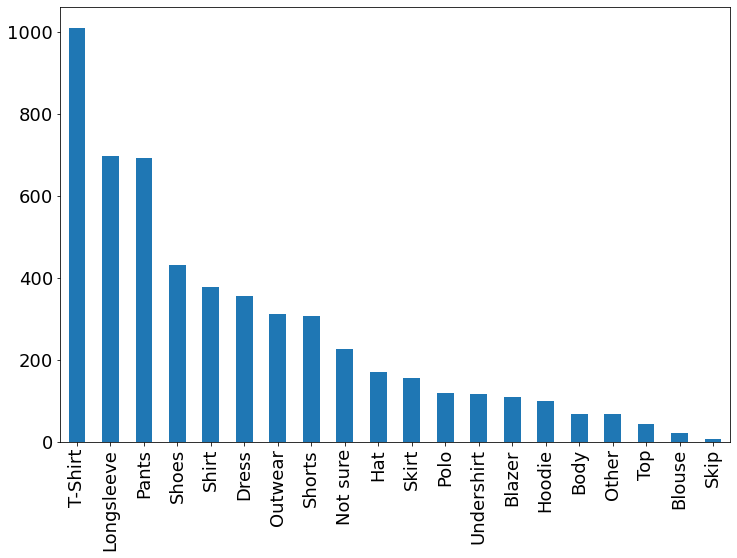

In [6]:

dataset_metadata['label'].value_counts().plot(kind='bar',figsize=(12,8),fontsize=18)

# Notes
1. Heavy imbalance in the classes distribution
2. I will ignore the class Not sure because it doesn't make sense to me.

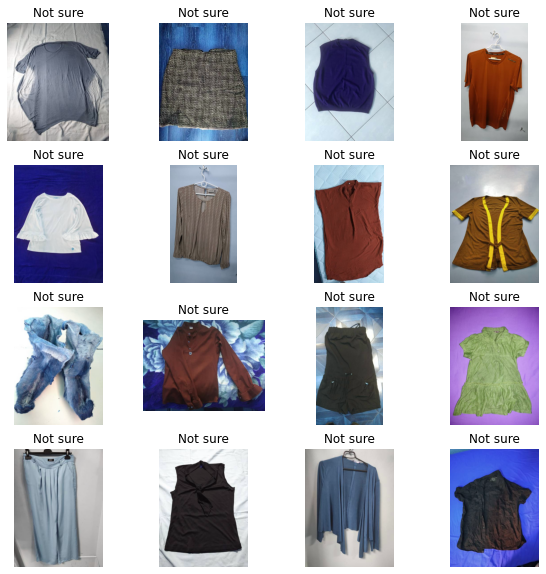

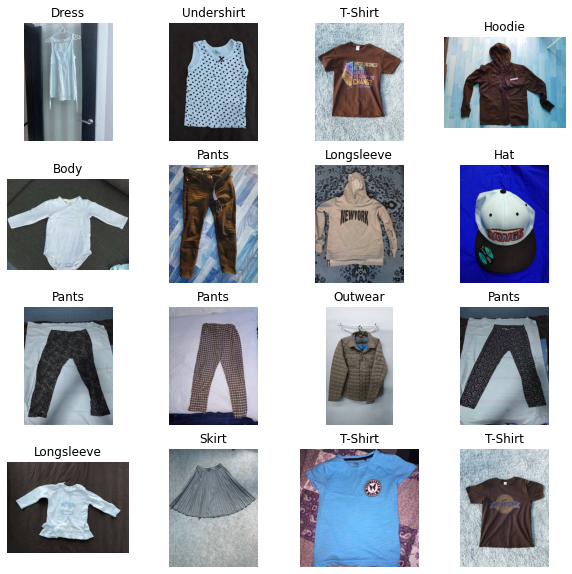

In [ ]:
# Not sure label
sample_unsure_ids = np.random.choice(dataset_metadata[dataset_metadata['label']=='Not sure']['image'],16)
visualize_images(sample_unsure_ids,["Not sure"]*len(sample_unsure_ids),images_path)

# Ordinary images
idxs = np.random.choice(dataset_metadata.shape[0],16)
sample_ids = dataset_metadata.iloc[idxs]['image'].values
sample_labels =dataset_metadata.iloc[idxs]['label'].values
visualize_images(sample_ids,sample_labels,images_path)


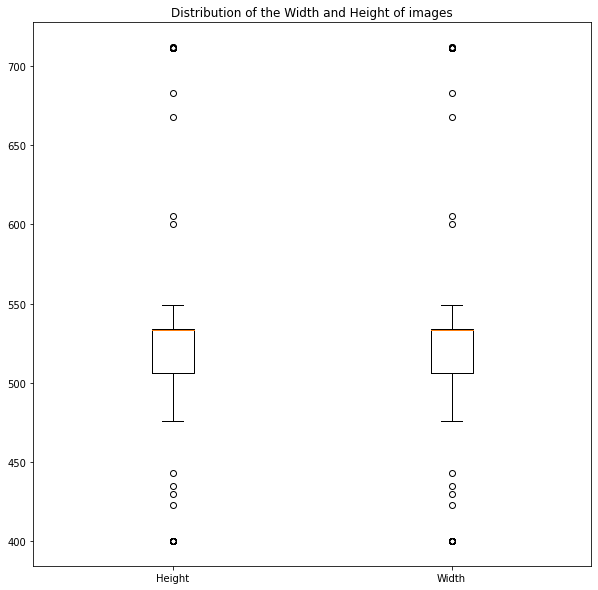

Mean Height, Width 521.54 429.05333333333334
Median Height, Width 533.0 400.0
STD Height, Width 76.55217218777445 77.12602558295235


In [ ]:

# Get a sense of the data dims
# sample a 150 random images
# see the width and heights
plt.figure(figsize=(10, 10))
indices = np.random.choice(np.arange(dataset_metadata.shape[0]),150)
hs,ws = [],[]
for img_id in dataset_metadata.iloc[indices]['image']:
  h,w,_ = cv2.imread(get_image_path(img_id,images_path)).shape
  hs.append(h),ws.append(w)
plt.boxplot([hs,hs])
plt.xticks(ticks=[1,2],labels=['Height','Width'])
plt.title("Distribution of the Width and Height of images")
plt.show()
print("Mean Height, Width",np.mean(hs),np.mean(ws))
print("Median Height, Width",np.median(hs),np.median(ws))
print("STD Height, Width",np.std(hs),np.std(ws))

The data has high variability in the width and height. However, the numbers hover around 530x400 ... I will start by warping the images, i.e. not preserving the aspect ratio.

In [7]:
# remove the Not sure data
filtered_meta = dataset_metadata[dataset_metadata['label']!='Not sure']

# Split the data with a percentage from each class for train/validation
def split_data_per_label(metadata_file,split_ratio=0.8,shuffle=True):
  """Split the data per label, i.e. takes a fixed percentage from each label.

  Args:
      metadata_file ([type]): The csv meta file
      split_ratio (float, optional): Train to validation ratio. Defaults to 0.8.
      shuffle (bool, optional): To shuffle the dataset. Defaults to True.

  Returns:
      [type]: train_x,train_y, val_x,val_y
  """
  split_ratio = 0.8
  labels = metadata_file['label'].unique()
  train_indx, validation_idx = [],[]
  # loop for every label, get a percentage for the train and validation, i.e. 80:20%
  for label in tqdm.tqdm(labels):
    print("Splitting for ",label)
    idxs = np.argwhere((metadata_file['label'] == label).values)
    if shuffle:
      np.random.shuffle(idxs)
    split_index = int(split_ratio * len(idxs))
    # print("Train, Validate samples ",split_index,len(idxs)-split_index)
    train_indx.append(idxs[:split_index])
    validation_idx.append(idxs[split_index:])
  
  train_indx, validation_idx = np.vstack(train_indx)[:,0],np.vstack(validation_idx)[:,0]
  if shuffle:
    np.random.shuffle(train_indx)
    np.random.shuffle(validation_idx)
  return metadata_file.iloc[train_indx]['image'],metadata_file.iloc[train_indx]['label'],\
      metadata_file.iloc[validation_idx]['image'],metadata_file.iloc[validation_idx]['label']

train_x,train_y, val_x,val_y = split_data_per_label(filtered_meta)

# Convert categorical labels into numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_y)
train_y = le.transform(train_y)
val_y = le.transform(val_y)

train_x, val_x = train_x.values, val_x.values
# le.classes_

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 409.08it/s]


Splitting for  T-Shirt
Splitting for  Shoes
Splitting for  Shorts
Splitting for  Shirt
Splitting for  Pants
Splitting for  Skirt
Splitting for  Other
Splitting for  Top
Splitting for  Outwear
Splitting for  Dress
Splitting for  Body
Splitting for  Longsleeve
Splitting for  Undershirt
Splitting for  Hat
Splitting for  Polo
Splitting for  Blouse
Splitting for  Hoodie
Splitting for  Skip
Splitting for  Blazer


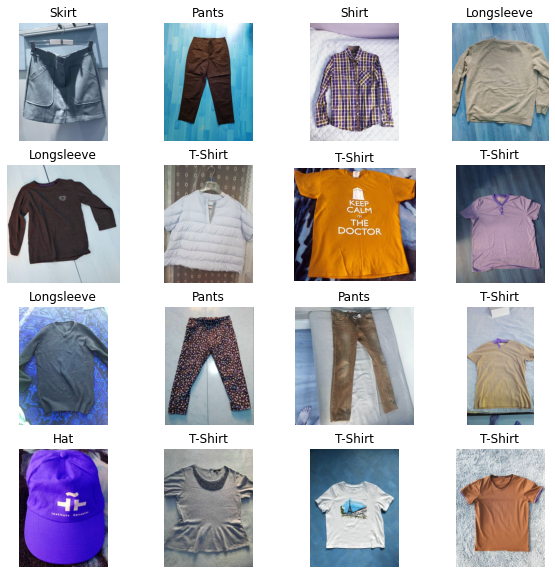

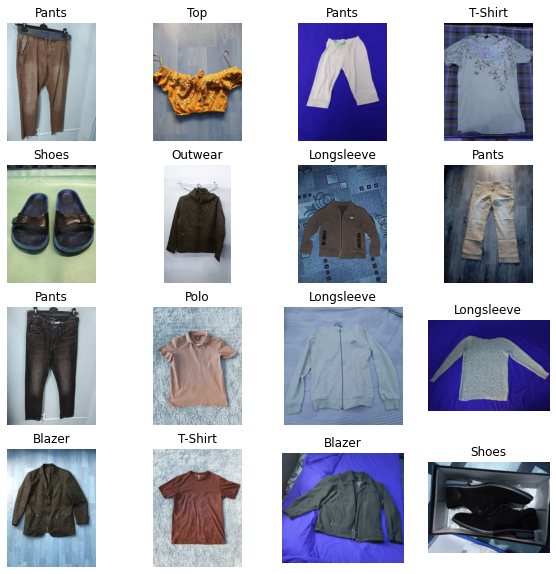

In [ ]:
# Make sure you didn't mess with the data order
visualize_images(val_x[:16],le.inverse_transform(val_y[:16]),images_path)
visualize_images(train_x[:16],le.inverse_transform(train_y[:16]),images_path)

# Build data laders

In [8]:
def load_image(path,target_shape=(256,256),normalize=True):
  # print(path.decode(),os.path.exists(path),os.path.isfile(path))
  try:
    if not os.path.exists(path):
      print("Path does not exist",path)
  except Exception as e:
    print("Error checking the path",path)
  # print(target_shape)
  image = cv2.imread(path.decode())
  image = cv2.resize(image,tuple(target_shape))
  
  if normalize:
    processed_image = np.empty(image.shape,dtype=np.float32)
    for c in range(image.shape[-1]):
      mini,maxi = image[:,:,c].min(),image[:,:,c].max()
      processed_image[:,:,c] = (image[:,:,c]-mini)/(maxi-mini)
  else:
    processed_image = image.astype(np.float32)
  return processed_image

# plt.imshow(load_image(get_image_path(train_x[5],images_path)))
INPUT_SIZE = 256
BS = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.map(lambda x,y: (tf.numpy_function(load_image,[get_image_path_tf(x,images_path),(256,256),False]\
                ,tf.float32),y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BS)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_dataset = val_dataset.map(lambda x,y: (tf.numpy_function(load_image,[get_image_path_tf(x,images_path),(256,256),False]\
                ,tf.float32),y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BS)

2021-11-25 01:43:17.757726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 01:43:17.760866: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Build the model

In [7]:
def build_model(baseline='effecientnet',input_size=(256,256,3),num_classes=19,training=True,\
                fine_tune=False,augment=False,load_weights=None,fine_tune_cut=100):
  """Create the model with the two heads
  baseline: effecientnet or vgg or mobilenet

  Args:
      baseline (str, optional): [description]. Defaults to 'effecientnet'.
      input_size (tuple, optional): [description]. Defaults to (256,256,3).
      num_classes (int, optional): [description]. Defaults to 19.
      training (bool, optional): Whether in the training mode or not. Defaults to True.
      augment (bool, optional): If given will add augmentation to the input. Defaults to False.
      load_weights ([type], optional): The path to the weights to load. Defaults to None.
      fine_tune_cut (int, optional): The number of layers to keep freezed if given fine_tune. Defaults to 100.

  Raises:
      NotImplementedError: If the passed model base anything but effecient.

  Returns:
      [type]: [description]
  """
  keras.backend.clear_session()
  if baseline == 'effecientnet':
    base_model = EfficientNetB0(include_top=False,weights='imagenet',input_shape=input_size,pooling='avg')
  else:
    raise NotImplementedError("Add other types here if you wish.")
  inputs = layers.Input(input_size)

  if fine_tune:
    # Stop training for transfer learning
    base_model.trainable  = True
    #print(len(base_model.layers))
    for layer in base_model.layers[:fine_tune_cut]:
      layer.trainable =  False
  else:
    base_model.trainable  = False
  
  if training and augment:
    
    data_augmentation = keras.Sequential(layers=[layers.RandomFlip('vertical'),layers.RandomRotation(0.2),\
                        layers.RandomZoom(height_factor=(0.1,0.2))])
    x = data_augmentation(inputs)
    # has no effect, weird!
    x = preprocess_input(x)
  else:
    x = inputs
  # Stop training mode as well
  # In order not to ruin the BN in case of fine-tuning
  x = base_model(x,training=False)
  
  classification = layers.Dense(num_classes,activation='softmax',name='final_classification')(x)

  model = keras.Model([inputs],[classification])
  if load_weights is not None:
    model.load_weights(load_weights)
  if training:
    # compile the model
    lr = 1e-5 if fine_tune else 1e-3
    print("lr",lr)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
  return model
  

In [10]:
# ckpt_path = os.path.join(os.path.split(dataset_path)[0],"checkpoint")
model = build_model(num_classes=len(filtered_meta['label'].unique()),input_size=(INPUT_SIZE,INPUT_SIZE,3),load_weights=None)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
final_classification (Dense) (None, 19)                24339     
Total params: 4,073,910
Trainable params: 24,339
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
# Step one you need to train the last layer you added
ckpt_path = os.path.join(".","checkpoint","weights.{epoch:04d}.ckpt")
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3,verbose=1),
             keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True,mode='min',save_weights_only=True)]

In [12]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=12,callbacks=callbacks)

2021-11-25 01:44:31.748325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
129/129 [==============================] - 168s 1s/step - loss: 1.3049 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.8853 - val_sparse_categorical_accuracy: 0.7553
Epoch 2/12
129/129 [==============================] - 163s 1s/step - loss: 0.7312 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.7879
Epoch 3/12
129/129 [==============================] - 163s 1s/step - loss: 0.5949 - sparse_categorical_accuracy: 0.8302 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.8042
Epoch 4/12
129/129 [==============================] - 162s 1s/step - loss: 0.5181 - sparse_categorical_accuracy: 0.8484 - val_loss: 0.6169 - val_sparse_categorical_accuracy: 0.8186
Epoch 5/12
129/129 [==============================] - 166s 1s/step - loss: 0.4646 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.5931 - val_sparse_categorical_accuracy: 0.8196
Epoch 6/12
129/129 [==============================] - 162s 1s/step - loss: 0.4234 - sparse_cate

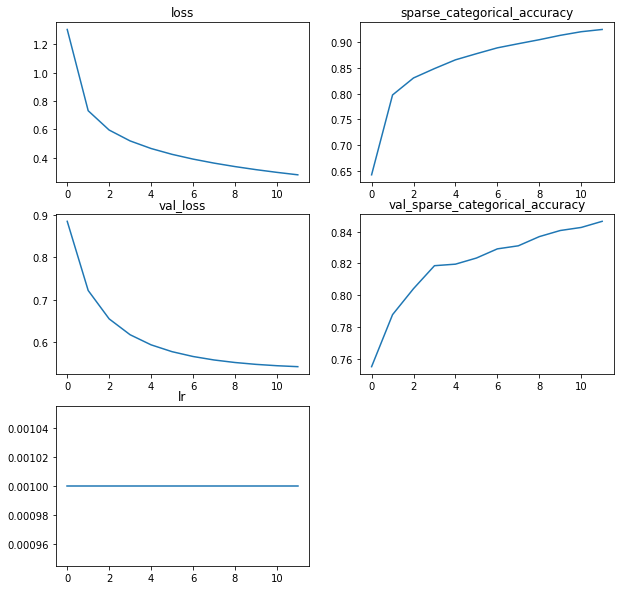

In [13]:
visualize_training_history(history.history)


100%|███████████████████████████████████████████| 33/33 [00:36<00:00,  1.10s/it]


(19, 19) 18


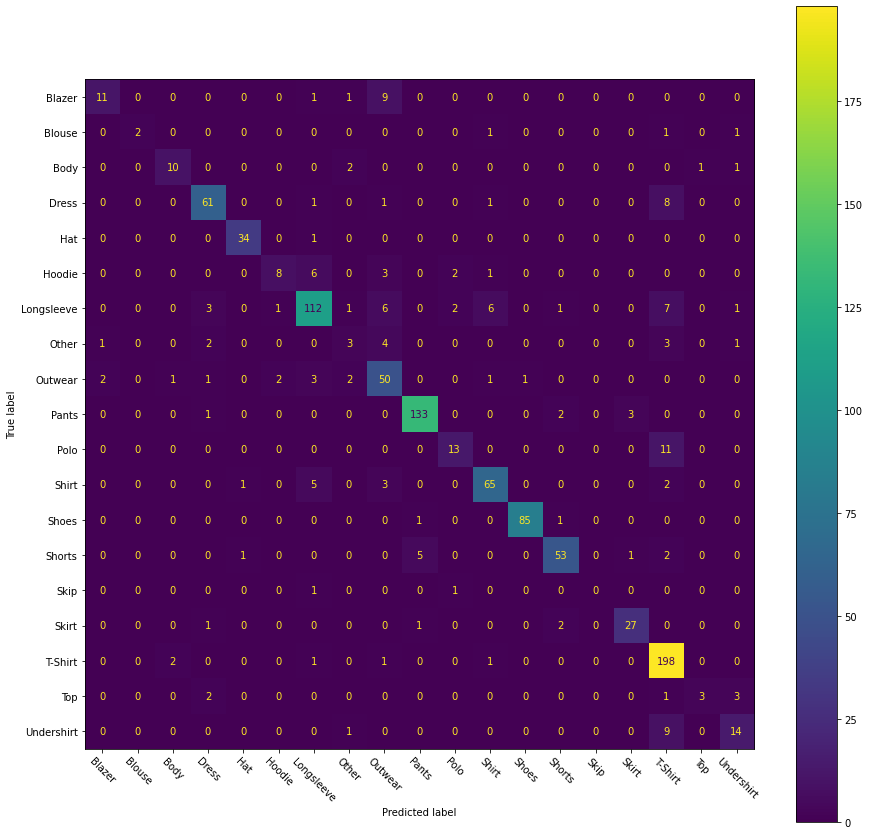

In [34]:


evaluate_model(val_dataset,le.classes_,False)

# Notes
The initial accuracy of the model after only 12 epochs was > 84%. Now, to enhance the accuracy even more I'm going to open all the layers for tuning.
1. The model is doing goofd job for most classes
2. For the classes with low accuracy like "T-Shirt", we find the model confusing that with "T-Shirt" and "Undershirt" which are very similar to each other. Also, the same observation holds true when looking at "T-Shirt" and "Polo". Both are t-shirts, so it makes sense to be of difficult categories.

In [69]:
ckpt_path = tf.train.latest_checkpoint(os.path.join(".","checkpoint"))
print(ckpt_path)
model = build_model(num_classes=len(filtered_meta['label'].unique()),input_size=(INPUT_SIZE,INPUT_SIZE,3),\
                    load_weights=ckpt_path,fine_tune=True,fine_tune_cut=230)
model.summary()

./checkpoint/weights.0012.ckpt
lr 1e-05
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
final_classification (Dense) (None, 19)                24339     
Total params: 4,073,910
Trainable params: 862,227
Non-trainable params: 3,211,683
_________________________________________________________________


In [70]:
ckpt_path = os.path.join(".","checkpoint_transfer","weights.{epoch:04d}.ckpt")
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3,verbose=1),
             keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=True)]
history = model.fit(train_dataset,validation_data=val_dataset,epochs=15,callbacks=callbacks)

Epoch 1/15
129/129 [==============================] - 186s 1s/step - loss: 0.8344 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.5781 - val_sparse_categorical_accuracy: 0.8349
Epoch 2/15
129/129 [==============================] - 185s 1s/step - loss: 0.3450 - sparse_categorical_accuracy: 0.8891 - val_loss: 0.5952 - val_sparse_categorical_accuracy: 0.8445
Epoch 3/15
129/129 [==============================] - 181s 1s/step - loss: 0.1955 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.6819 - val_sparse_categorical_accuracy: 0.8330
Epoch 4/15
129/129 [==============================] - 187s 1s/step - loss: 0.1099 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.7846 - val_sparse_categorical_accuracy: 0.8301

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/15
129/129 [==============================] - 177s 1s/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.7471 - val_sparse_categorical_accuracy: 0.8388
Epoch 6/15
129

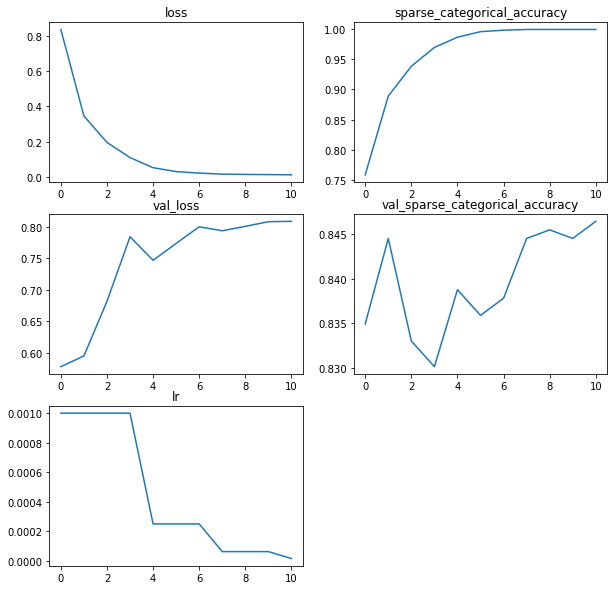

In [71]:
visualize_training_history(history.history)

100%|███████████████████████████████████████████| 33/33 [00:36<00:00,  1.12s/it]


(19, 19) 18


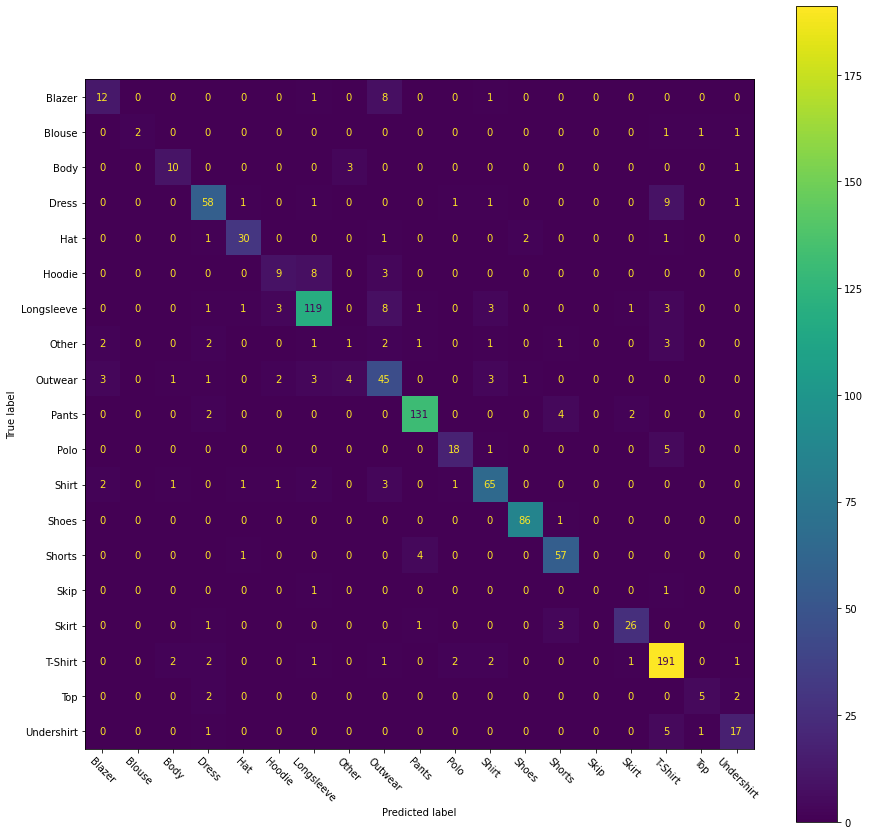

In [72]:
evaluate_model(val_dataset,le.classes_,False)

# Adding Augmentation 
Now I'm going to add some data augmentation since fine-tuning just made the model to overfit more.
The augmentations that I find makes the most sense are 
1. Scaling
2. Rotation
3. Flipping

In [10]:
ckpt_path = tf.train.latest_checkpoint(os.path.join(".","checkpoint_transfer"))
print(ckpt_path)
model = build_model(num_classes=len(filtered_meta['label'].unique()),input_size=(INPUT_SIZE,INPUT_SIZE,3),\
                    load_weights=ckpt_path,fine_tune=True,fine_tune_cut=230,augment=True)
ckpt_path = os.path.join(".","checkpoint_transfer_aug","weights.{epoch:04d}.ckpt")
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3,verbose=1),
             keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=True)]
history = model.fit(train_dataset,validation_data=val_dataset,epochs=15,callbacks=callbacks)